# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Tesnim Gotrane]([link](https://github.com/gotrane))
- [Saad Mhamdi]([link](https://github.com/saadmhd07))


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

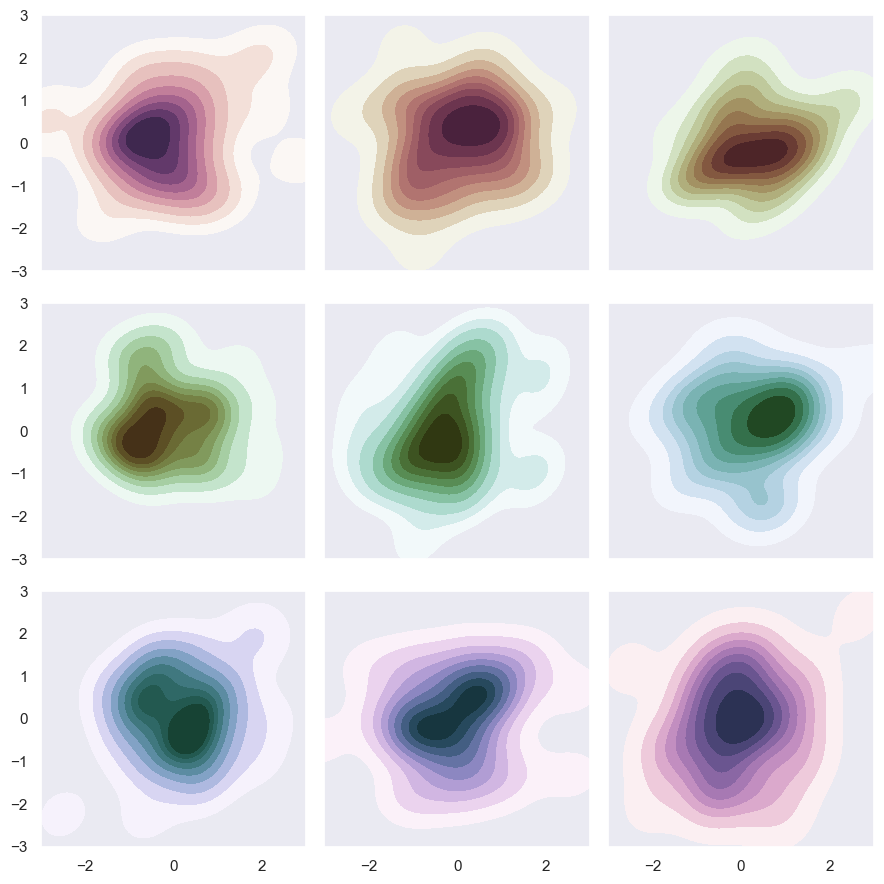

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

La méthode sns.kdeplot est utilisée pour créer un graphe de densité par noyau (KDE), qui estime et visualise la fonction de densité de probabilité d'une variable aléatoire. Dans ce cas, il s'agit d'un KDE bivarié où l'on trace la densité jointe des deux variables x et y. Le KDE est une méthode de lissage permettant d'obtenir une estimation continue des données sous-jacentes, montrée ici sous forme de contours colorés.
cmap : La palette de couleurs est définie à l'aide de cubehelix_palette, qui génère un gradient de couleurs. Ce gradient est appliqué à la courbe de densité, avec des couleurs plus sombres pour les densités plus élevées.

shade=True : L'option shade remplit la zone sous la courbe de densité avec de la couleur, rendant les régions de densité plus élevée plus visibles, et offrant un contraste visuel plus fort pour les zones de haute et de basse densité.
cut=5 : Cette option permet d'étendre l'estimation KDE au-delà de la plage des données d'origine par un facteur de 5, ce qui permet un lissage plus large.

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

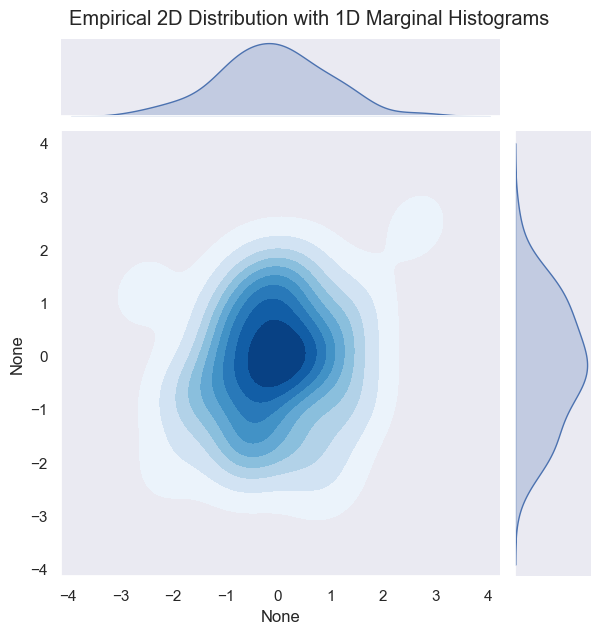

In [3]:
# on prend la dernière réalisation de x et y 
# On utilise sns.jointplot pour dessiner la 2D KDE et histogrammes marginaux
sns.jointplot(x=x, y=y, kind="kde", fill=True, cmap="Blues")
plt.suptitle("Empirical 2D Distribution with 1D Marginal Histograms", y=1.02)
plt.show()

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

**Answer:**

In [4]:
import os
print(os.cpu_count()) 

8


In [5]:
def markov(rho, A, nmax, rng) :
    N = A.shape[0]
    assert (rho.shape[0] == N)
    assert np.all(rho>=0) #toutes les probabilités doivent être >= 0
    assert (rho.sum(0)==1) # vérifier que la somme des probabilités = 1
    assert (A.shape[0] == A.shape[1]) #vérifier que c'est une matrice carré
    #Vérifier que c'est une matrice stochastique
    assert np.all(A>=0) # tous les éléments de A doivent être >=0
    assert np.all(A.sum(1) == np.ones((N,))) #la somme de chaque ligne de A est égale à 1 
    
    states = np.arange(N)
    X = [rng.choice(states,p=rho)]
    for _ in range(nmax-1) :
        current_state = X[-1]
        next_state = rng.choice(states,p=A[current_state])
        X.append(next_state)
    return X
    

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

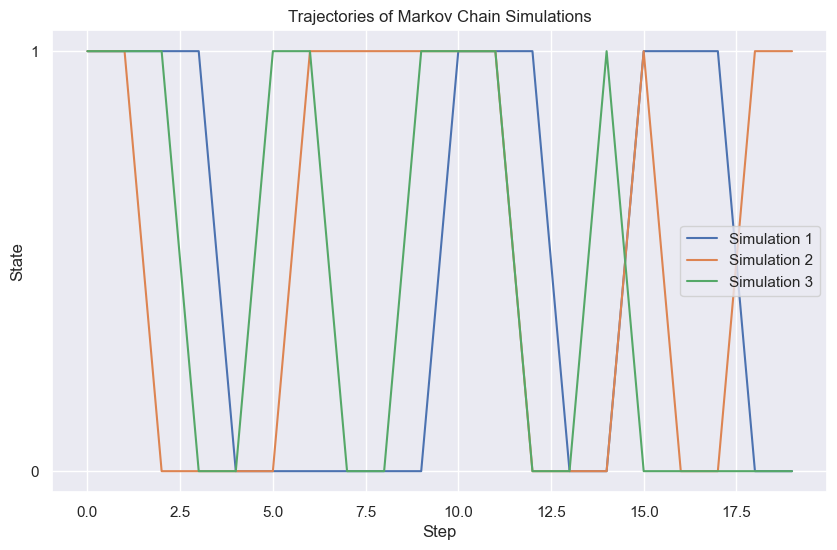

In [6]:
# Definir la distribution initiale et la matrice de transition
rho = np.array([0.5, 0.5])  # Proba d'Etat initial
A = np.array([[0.8, 0.2],  # Matrice de transition
              [0.3, 0.7]])

nmax = 20  # Nombre de steps dans la Markov chain

# Performer plusieurs simulations
num_simulations = 3
plt.figure(figsize=(10, 6))

for i in range(num_simulations):
    rng = np.random.default_rng(50 + i)  # Differentes graines pour chaque simulation
    chain = markov(rho, A, nmax, rng)
    plt.plot(chain, label=f'Simulation {i+1}')

# Plot details
plt.title('Trajectories of Markov Chain Simulations')
plt.xlabel('Step')
plt.ylabel('State')
plt.yticks(np.arange(len(rho)))  # States are 0, 1
plt.legend()
plt.grid(True)
plt.show()

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

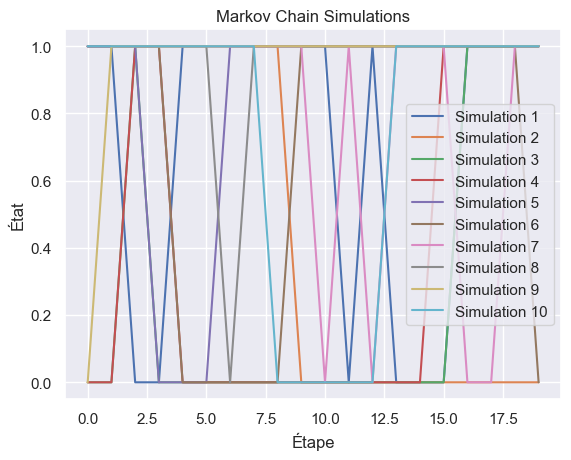

Multiprocessing execution time: 0.6304 seconds


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool 
from markov import * #importer la fonction implémentée dans le fichier markov.py
import time

# Definir la liste des probabilités intiale et la matrice de transition
rho = np.array([0.5, 0.5])  # State de probabilités initial
A = np.array([[0.8, 0.2],  # Matrice de transition 'simple'
              [0.1, 0.9]])

nmax = 20  # Nombre de steps dans la Markov chain
num_simulations = 10  # Nombre de simulations
R = [np.random.default_rng(i) for i in range(num_simulations)]
params = [(rho,A,nmax,r) for r in R]
start_time = time.time()
pool=Pool(3)
simulations = pool.starmap_async(markov, params).get()
pool.close()
end_time = time.time()  # Temps de fin
multiprocessing_execution_time = end_time - start_time  # Calculer le temps d'exécution

for i, sim in enumerate(simulations):
    plt.plot(sim, label=f'Simulation {i+1}')
plt.xlabel('Étape')
plt.ylabel('État')
plt.title('Markov Chain Simulations')
plt.legend()
plt.grid(True)
plt.show()

# Print le temps d'éxecution
print(f"Multiprocessing execution time: {multiprocessing_execution_time:.4f} seconds")

4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

Dask execution time: 0.1039 seconds


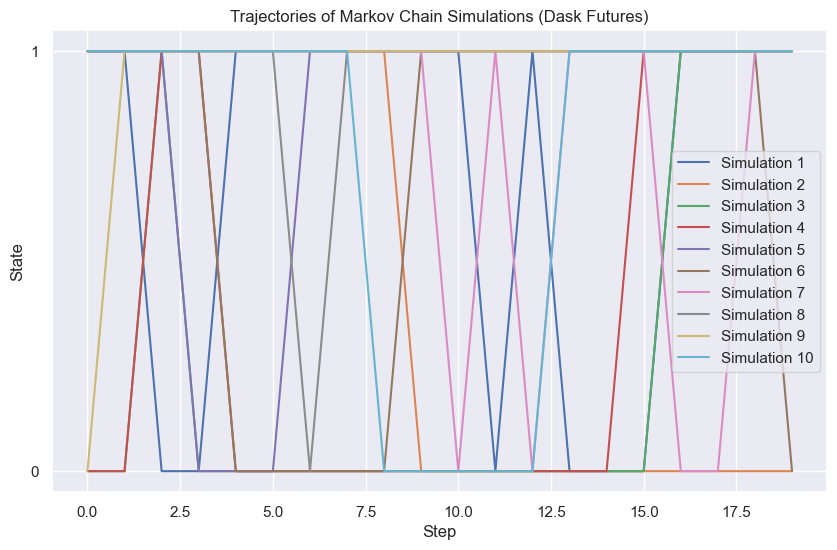

In [8]:
from dask.distributed import Client
from markov import *

# Create a Dask client (use 'threads' for multithreading or 'processes' for multiprocessing)
client = Client()  # You can specify the number of workers if needed

# Start timing
start_time = time.time()

# Use dask to submit tasks
futures = [client.submit(markov, *param) for param in params ]

# Gather the results as they complete
results = client.gather(futures)

# Measure the time for dask execution
end_time = time.time()
execution_time = end_time - start_time
print(f"Dask execution time: {execution_time:.4f} seconds")

# Plot the results
plt.figure(figsize=(10, 6))
for i, chain in enumerate(results):
    plt.plot(chain, label=f'Simulation {i+1}')
plt.title('Trajectories of Markov Chain Simulations (Dask Futures)')
plt.xlabel('Step')
plt.ylabel('State')
plt.yticks(np.arange(len(rho)))  # States are 0, 1
plt.legend()
plt.grid(True)
plt.show()

# Close the Dask client
client.close()

En utilisant Dask, on obtient un temps d'éxecution plus court.

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

Temps d'exécution avec Dask.bag: 0.3432 seconds


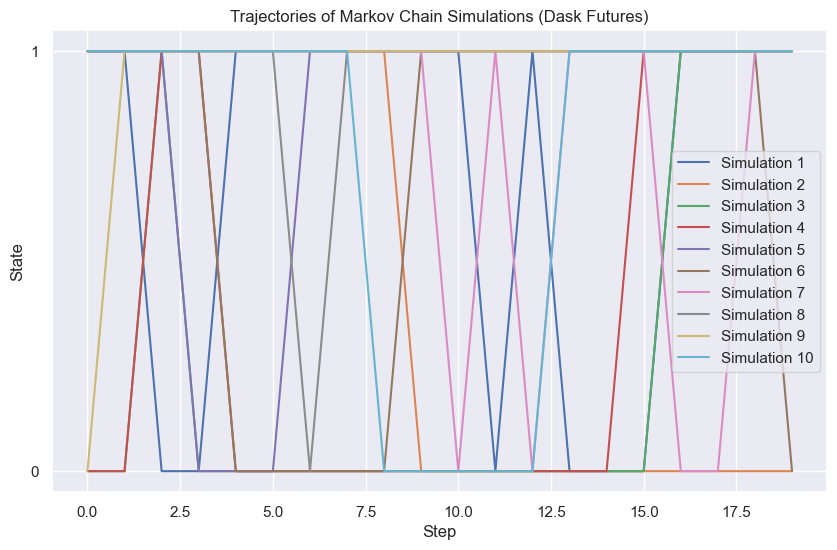

In [9]:
import dask.array as da
import numpy as np
import dask.bag as db

# Chronométrage
start_time = time.time()
params = [(rho, A, nmax, r) for r in R]

# Dask Client pour la gestion des tâches
client = Client()

# Chronométrage
start_time = time.time()

# Créer un bag Dask avec les paramètres
dask_bag = db.from_sequence(params, npartitions=num_simulations)

# Appliquer la fonction de simulation à chaque ensemble de paramètres
simulations = dask_bag.map(lambda p: markov(*p)).compute()

end_time = time.time()
dask_execution_time = end_time - start_time

# Afficher les résultats
print(f"Temps d'exécution avec Dask.bag: {dask_execution_time:.4f} seconds")
plt.figure(figsize=(10, 6))
for i, chain in enumerate(simulations):
    plt.plot(chain, label=f'Simulation {i+1}')
plt.title('Trajectories of Markov Chain Simulations (Dask Futures)')
plt.xlabel('Step')
plt.ylabel('State')
plt.yticks(np.arange(len(rho)))  # States are 0, 1
plt.legend()
plt.grid(True)
plt.show()

Contrairement à dask.array, on a pu ici utilisé dask.bag pour traiter les collections de paramètres qu'on avait. On a par ailleurs un temps d'éxecution plus lent mais c'est prévisible. Les méthodes parallèles sont plus performantes avec des grands nombres de données et des calculs plus complexes et coûteux.